- references
    - https://gibberblot.github.io/rl-notes/intro.html

In [21]:
from IPython.display import Image
from collections import defaultdict
from matplotlib import animation
import matplotlib.pyplot as plt

In [22]:
import sys
import os
sys.path.append(os.path.abspath('../'))

## MDPs with $P$ and $R$

$$
M = \langle S, s_0, A, P_a(s'\mid s), r(s,a,s'), \gamma\rangle
$$

- solving MDPs 
    - finding the optimal policy: $\pi(s)$
- 补充说明一下马尔科夫性（描述的是环境的转移函数）
    - $P(S_{t+1}|S_t,A_t)=P(S_{t+1}|\underbrace{S_t,A_t,S_{t-1}, A_{t-1}, ...}_{完整的交互历史})$
- 一些记号的问题
    - $P_a(s'|s)=P(s'|s,a)=P(S_{t+1}=s'|S_t=s,A_t=a)$

### bellman equation & value iteration

- value iteration algorithm
    - input：MDP，$M = \langle S, s_0, A, P_a(s' \mid s), r(s,a,s'), \gamma\rangle$
    - output: $V(s)$, value function（关于状态 $s$）

$$
\begin{split}
V^*(s)=\max_{a\in A}\sum_{s'\in S}P(s'|s,a)\left[R(s,a,s')+\gamma V^*(s')\right]\\
Q(s,a)=\sum_{s'\in S}P(s'|s,a)\left[R(s,a,s')+\gamma V^*(s')\right]
\end{split}
$$

- 这里如果reward function只跟当前状态 $s$ 以及当前状态选择的动作 $a$ 有关（而与 $s'$ 无关），$r(s,a)$，则显然公式可以重写为

$$
\begin{split}
V^*(s)=\max_{a\in A}R(s,a)+\sum_{s'\in S}P(s'|s,a)\left[\gamma V^*(s')\right]\\
Q(s,a)=R(s,a,s')+\sum_{s'\in S}P(s'|s,a)\left[\gamma V^*(s')\right]
\end{split}
$$

- $\sum_{s'\in S}P_a(s'|s)=1, \forall a\in A(s)$
- 状态 $V^*(s)$ 的递归定义；
- iteratively solve via dynamic programming: 子问题，
    - start with $V_0(s)=0$ for all states $s$
        - $V_{t+1}(s)\leftarrow \max_{a\in A}\sum_{s'\in S}P(s'|s,a)\left[R(s,a,s')+\gamma V_t(s')\right]$
    - 迭代更新 bellman equation 直到收敛


### $V(s)$ 与 $Q(s,a)$, $\pi(s)$ 的讨论

- $V(s)=\max_{a\in A(s)}Q(s,a)$
- 注意这里还不是 Q-learning
    - $Q(s,a):=Q(s,a)+\alpha[r+\gamma \max_{a'}Q(s',a') - Q(s,a)]$
- $\pi(s)\in A$，策略 policy 接受一个 state，返回一个 action
    - 也分 DeterministicPolicy 与 StochasticPolicy
    - 可以从 $V(s)$ 中提取得到 $\pi(s)$

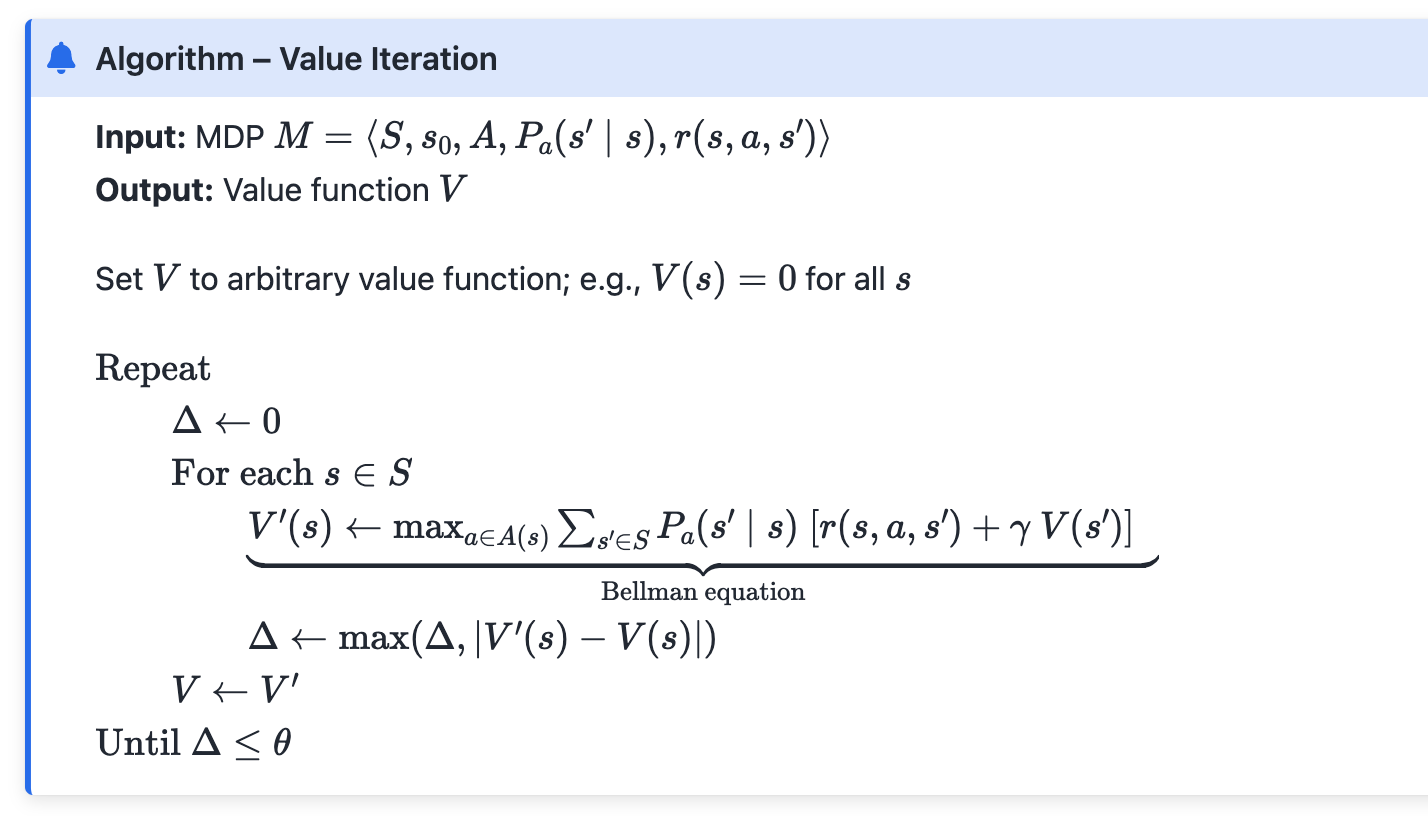

In [7]:
Image('./imgs/value_iter.png', width=500)

- $\sum_{s'\in S}$：遍历所有的可能转移到的状态；
- 分析下时间复杂度
    - $|S|\cdot \left(|A|\cdot |S|\right) \rightarrow O\left(|S|^2\cdot|A|\right) \rightarrow O(|S|^2|A|\cdot n)$
    - $n$：最外层迭代次数；

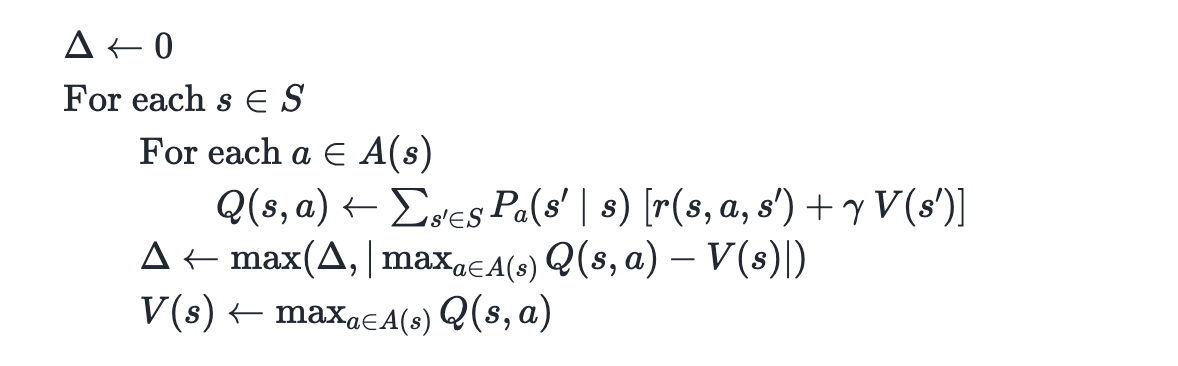

In [8]:
Image('./imgs/q_values.png', width=500)

## grid world

- value function: $V(s)$（关于状态 $s$ 的价值函数）
    - 数据结构：`defaultdict(lambda: 0.)`（key：state）
- q table：$Q(s,a)$
    - 数据结构：`defaultdict(lambda: 0.)`（key：(state, action)）
- 以上两个都是离散状态

In [3]:
class ValueIteration:
    def __init__(self, mdp):
        self.mdp = mdp
        self.V = defaultdict(lambda: 0.0)
        self.Q = defaultdict(lambda: 0.0)

    def value_iteration(self, max_iterations=100, theta=0.001):

        for i in range(max_iterations):
            delta = 0.0
            new_values = defaultdict(lambda: 0.0)
            # 状态空间，遍历所有的状态
            for state in self.mdp.get_states():
#                 # 计算 q(state, a) given state
#                 qtable = defaultdict(lambda: 0.)
                # 动作空间: 当前状态 state 下允许转移的 action（valid action）
                for action in self.mdp.get_actions(state):
                    # Calculate the value of Q(s,a)
                    new_value = 0.0
                    for (new_state, probability) in self.mdp.get_transitions(state, action):
                        # instant reward
                        reward = self.mdp.get_reward(state, action, new_state)
                        new_value += probability * (
                            reward + (self.mdp.get_discount_factor() * self.V[new_state])
                        )
#                     qtable[(state, action)] = new_value
                    self.Q[(state, action)] = new_value

                # V(s) = max_a Q(sa)
                max_q = float('-inf')
                arg_max_q = None
                for action in self.mdp.get_actions(state):
                    if max_q < self.Q[(state, action)]:
                        max_q = self.Q[(state, action)]
                        arg_max_q = action 
                        
                delta = max(delta, abs(self.V[state] - max_q))
                new_values[state] = max_q

            self.V = new_values.copy()
            print(f'iteration: {i}, max delta: {delta}')
            # Terminate if the value function has converged
            if delta < theta:
                return i

In [24]:
# os.chdir('./utils') 

In [25]:
from utils import gridworld

In [26]:
gw = gridworld.GridWorld()

In [27]:
model = ValueIteration(gw)

In [28]:
model.value_iteration()

iteration: 0, max delta: 1.0
iteration: 1, max delta: 0.7200000000000001
iteration: 2, max delta: 0.5184000000000001
iteration: 3, max delta: 0.3732480000000001
iteration: 4, max delta: 0.26873856000000007
iteration: 5, max delta: 0.21347919360000006
iteration: 6, max delta: 0.13127206809600006
iteration: 7, max delta: 0.07603935720192012
iteration: 8, max delta: 0.03713760877501443
iteration: 9, max delta: 0.017503646213894386
iteration: 10, max delta: 0.00782998158524284
iteration: 11, max delta: 0.006619227655718318
iteration: 12, max delta: 0.003824154683289116
iteration: 13, max delta: 0.002105095303100324
iteration: 14, max delta: 0.0010683398432171365
iteration: 15, max delta: 0.0005207601015905228


15

In [29]:
model.V

defaultdict(<function __main__.ValueIteration.value_iteration.<locals>.<lambda>()>,
            {('terminal', 'terminal'): 0.0,
             (0, 0): 0.4905111290848818,
             (0, 1): 0.5662859470207978,
             (0, 2): 0.6449604156579638,
             (1, 0): 0.430392831592005,
             (1, 2): 0.7443799065969555,
             (2, 0): 0.47534495797204973,
             (2, 1): 0.5718588780335343,
             (2, 2): 0.847766223163821,
             (3, 0): 0.2770747941588517,
             (3, 1): -1.0,
             (3, 2): 1.0})

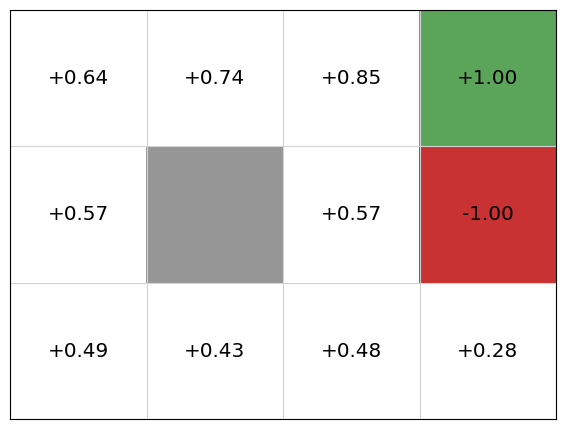

In [30]:
gw.visualise_value_function(model.V)

### policy extraction from $V(s)$

$$
\begin{split}
\pi(s)&={\arg\max}_{a\in A(s)}\sum_{s'\in S}P_a(s'|s)\left[r(s,a,s')+\gamma V(s)\right]
\end{split}
$$

- 这个时候最右边的 $V(s)$ 已经是经过 value iteration 计算出来的最终的 value function, 可直接索引使用；

- 假如当前状态 $s_0$ 下，有两个动作可选 $(a,b)\in A(s_0)$
    - $a$ => 0.1 `*` 100 + 0= 10
        - 0.1, $s$, $V(s)=100$ 
        - 0.9, $s'$, $V(s')=0$ 
    - $b$ => 0.5`*`50 + 0.5`*`90=70
        - 0.5, $t$, $V(t)=50$
        - 0.5, $t'$, $V(t')=90$

In [12]:
def get_q_value(mdp, s, a, V):
    q_value = 0.0
    for (next_s, p) in mdp.get_transitions(s, a):
        r = mdp.get_reward(s, a, next_s)
#         print(s, a, next_s, p, r)
        q_value += p*(r + mdp.discount_factor * V[next_s])
    return q_value

def extract_policy(mdp, V):
    policy = defaultdict(lambda: None)
    for s in mdp.get_states():
        max_q = float('-inf')
        for a in mdp.get_actions(s):
            cur_q = get_q_value(mdp, s, a, V)
#             print(s, a, cur_q)
            if cur_q > max_q:
                max_q = cur_q
                policy[s] = a
    return policy

In [31]:
policy = extract_policy(gw, model.V)
policy

defaultdict(<function __main__.extract_policy.<locals>.<lambda>()>,
            {('terminal', 'terminal'): 'terminate',
             (0, 0): '▲',
             (0, 1): '▲',
             (0, 2): '►',
             (1, 0): '◄',
             (1, 2): '►',
             (2, 0): '▲',
             (2, 1): '▲',
             (2, 2): '►',
             (3, 0): '◄',
             (3, 1): 'terminate',
             (3, 2): 'terminate'})

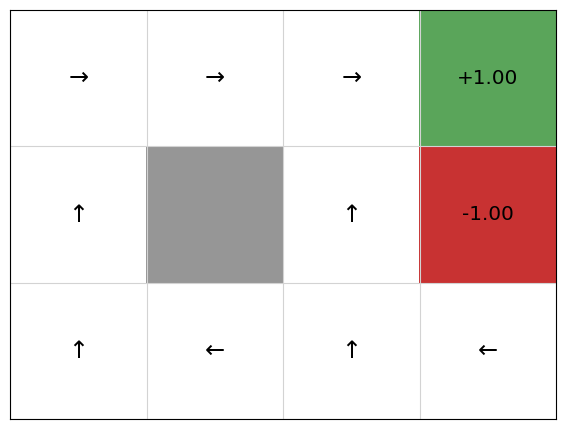

In [14]:
gw.visualise_policy(policy)

In [17]:
model.V

defaultdict(<function __main__.ValueIteration.value_iteration.<locals>.<lambda>()>,
            {('terminal', 'terminal'): 0.0,
             (0, 0): 0.4905111290848818,
             (0, 1): 0.5662859470207978,
             (0, 2): 0.6449604156579638,
             (1, 0): 0.430392831592005,
             (1, 2): 0.7443799065969555,
             (2, 0): 0.47534495797204973,
             (2, 1): 0.5718588780335343,
             (2, 2): 0.847766223163821,
             (3, 0): 0.2770747941588517,
             (3, 1): -1.0,
             (3, 2): 1.0,
             (1, 1): 0.0})

In [18]:
model.Q

defaultdict(<function __main__.ValueIteration.__init__.<locals>.<lambda>()>,
            {(('terminal', 'terminal'), 'terminate'): 0.0,
             ((0, 0), '▲'): 0.4905111290848818,
             ((0, 0), '▼'): 0.4358313274983339,
             ((0, 0), '◄'): 0.4481047986029814,
             ((0, 0), '►'): 0.40459683135234953,
             ((0, 1), '▲'): 0.5662859470207978,
             ((0, 1), '▼'): 0.4549397738012999,
             ((0, 1), '◄'): 0.5098678966436481,
             ((0, 1), '►'): 0.5098678966436481,
             ((0, 2), '▲'): 0.5894014364519162,
             ((0, 2), '▼'): 0.5327350648189662,
             ((0, 2), '◄'): 0.5733692434749165,
             ((0, 2), '►'): 0.6449604156579638,
             ((1, 0), '▲'): 0.39640443660932984,
             ((1, 0), '▼'): 0.39640443660932984,
             ((1, 0), '◄'): 0.430392831592005,
             ((1, 0), '►'): 0.4195334752343953,
             ((1, 2), '▲'): 0.6702974088148523,
             ((1, 2), '▼'): 0.6702974088148523